In [1]:
import numpy as np
from scipy import ndimage
from scipy.ndimage import binary_fill_holes
from astropy.io import fits
from tqdm import tqdm

def get_bright_pixels(img:np.array, threshold:float = 255)->np.array:
    """
    set to zero all pixels smaller than threshold
    """
    
    return np.where(img < threshold, 0, img)

def get_bright_objects_labels(labeled_img:np.array, bright_objects_slices:list)->list:
    """
    takes the labeled image and bright object slices and return a set with all the objects id in the labeled img
    corresponding to the bright objects slices locations
    """ 
    obj_ids = [set(labeled_img[s].flatten()) for s in bright_objects_slices]
    set_union = set().union(*obj_ids)
    set_union.remove(0)
    
    return list(set_union)

def get_mask(image:np.array, pixel_threshold:float)->np.array:
    """
    returns a mask for img using pixel_threshold as threshold for detecting bright objects
    """
    labeled_img,_ = ndimage.label(image)
    structure = ndimage.generate_binary_structure(2,2)
    
    bright_objects = get_bright_pixels(image,pixel_threshold)
    labeled_bright_objects,_ = ndimage.label(bright_objects, structure)
    bright_objects_slices = ndimage.find_objects(labeled_bright_objects)
    
    mask = labeled_img.copy()
    bright_obj_ids = get_bright_objects_labels(labeled_img, bright_objects_slices)
    out = np.where(np.isin(mask,bright_obj_ids),1,0)
    
    return 1-binary_fill_holes(out)


def apply_masks(fits_file:list, imgs:list, fields:str, pixel_threshold:float) -> dict:
    masked_fields = {}
    for f,im,field in zip(fits_file, imgs,fields):
        masked_field = []
        for i in range(len(f)):
            mask = get_mask(im[:,:,i],pixel_threshold=pixel_threshold)
            data = f[0].data*mask
            header = f[0].header
            masked_field.append((data, header))
        masked_fields[field] = masked_field
    
    return masked_fields
            

In [2]:
import numpy as np
import sys
import logging
import glob
import matplotlib.pyplot as plt

from astropy.io import fits
from tqdm import tqdm

from config import FIELDS, DATA_DIR, IMAGES_DIR, BANDS_TO_RGB, MASK_PIXEL_THRESHOLD
from download import download_fields
from img_processing import fits2rgb_processing
from utils import splus_conn, load_fits

file_handler = logging.FileHandler(filename="log.log", mode = "w")
stdout_handler = logging.StreamHandler(stream=sys.stdout)
logging.basicConfig(level = logging.INFO,
                    format="%(asctime)s [%(levelname)s] - %(name)s :%(message)s",
                    datefmt="%Y-%m-%d %I:%M:%S %p",
                    handlers=[stdout_handler, file_handler])

logger = logging.getLogger(__name__)


# logger.info("Downloading data...")
# splus_connection = splus_conn()
# download_fields(fields = FIELDS, bands = ['R','G','I'], save_path = DATA_DIR, splus_connection=splus_connection)

logger.info("Loading fits files ...")
fits_files = glob.glob(DATA_DIR+"*.fits")
fields = list(set([f.replace(DATA_DIR,"").split("_")[0] for f in fits_files]))

fits_data = []
for field in tqdm(fields):
        fits_data.append([load_fits(DATA_DIR+f"{field}_band_{band}.fits") for band in BANDS_TO_RGB])

logger.info("Creating RGB images ...")
imgs = fits2rgb_processing(fits_data = fits_data,Q = 8, stretch = 3)


2023-01-30 11:21:12 PM [INFO] - __main__ :Loading fits files ...


100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 105.39it/s]

2023-01-30 11:21:12 PM [INFO] - __main__ :Creating RGB images ...
2023-01-30 11:21:12 PM [INFO] - img_processing :Processing Fits ...



100%|█████████████████████████████████████████████| 2/2 [00:28<00:00, 14.38s/it]


In [3]:
logger.info("Applying masks ...")
for i in range(len(fits_data)):
    logger.info(f"Masking: {fields[i]}")
    masked = apply_masks([fits_data[i]], [imgs[i]], [fields[i]], pixel_threshold= MASK_PIXEL_THRESHOLD)
    for f,m in masked.items():
        for data,band in zip(m,BANDS_TO_RGB):
            savep = DATA_DIR + f + f"_{band}_masked.fits"
            
            fits.writeto(DATA_DIR + f + f"_{band}_masked.fits", data[0], data[1], overwrite = True) 


2023-01-30 11:22:21 PM [INFO] - __main__ :Applying masks ...
2023-01-30 11:22:21 PM [INFO] - __main__ :Masking: STRIPE82-0113
2023-01-30 11:23:26 PM [INFO] - __main__ :Masking: SPLUS-s28s34


In [29]:
imgs[0][:,:,0].max()

255

In [5]:
m = get_mask(imgs[0][:,:,1], MASK_PIXEL_THRESHOLD)

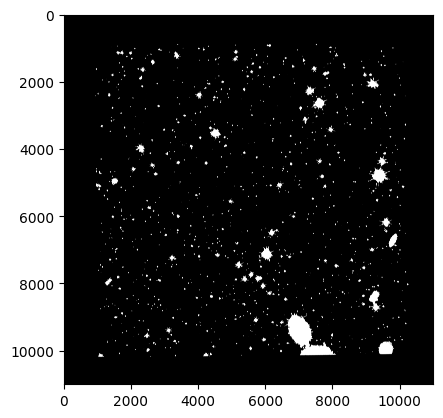

In [4]:
plt.imshow(m, cmap="gray_r")

In [6]:
masked

{'SPLUS-s28s34': [(array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]),
   SIMPLE  =                    T / conforms to FITS standard                      
   BITPIX  =                  -32 / array data type                                
   NAXIS   =                    2 / number of array dimensions                     
   NAXIS1  =                11000                                                  
   NAXIS2  =                11000                                                  
   EQUINOX =        2000.00000000 / Mean equinox                                   
   MJD-OBS =   5.841000000000E+04 / Modified Julian date at start                  
   RADESYS = 'ICRS    '           / Astrometric system                             
   CTYPE1  = 'RA---TAN'           / WCS projectio

TypeError: Image data of dtype <U18 cannot be converted to float

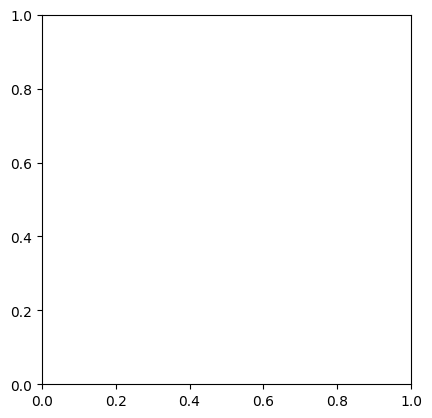

In [12]:
plt.imshow(masked['SPLUS-s28s34'][0][0], cmap="gray_r")

In [15]:
masked['SPLUS-s28s34'][0][0].min()

-4.250126838684082

In [ ]:

logger.info("Saving masked files ...")
for f,m in masked.items():
    for data,band in zip(m,BANDS_TO_RGB):
        savep = DATA_DIR + f + f"_{band}_masked.fits"
        logger.info(f"Saving data to: " + savep)
        fits.writeto(DATA_DIR + f + f"_{band}_masked.fits", data[0], data[1], overwrite = True) 
        plt.imsave(IMAGES_DIR + f + f'_{band}.png',arr=data[0][:,:,0] , cmap='gray_r')

logger.info("Saving RGB images ...")
for img,field in zip(imgs,fields):
    np.savez(IMAGES_DIR + f'{field}_rgb.npz', img = img) 
    plt.imsave(IMAGES_DIR + f'{field}.png',arr=img[:,:,0] , cmap='gray_r')